In [619]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RegNet(nn.Module):
    def __init__(self):
        super(RegNet, self).__init__()
        self.fc1 = nn.Linear(500,500)
        self.fc2 = nn.Linear(500,500)
        self.fc3 = nn.Linear(500,1,bias=False)
        self.dropout = nn.Dropout(0.25)
        self.thr = nn.Sigmoid()
        self.thr1 = nn.ReLU()
        self.thr2 = nn.LeakyReLU(0.1)

    def forward(self,x):
       # x=self.thr2(self.fc1(x))
        x=self.thr2(self.fc2(x))
        x=self.thr(self.fc3(x))
        return x 

#import hdf5storage
#mat = hdf5storage.loadmat('wrongsource.mat') 
import scipy.io
mat = scipy.io.loadmat('wrongsource1.mat')

import torch
#import h5py
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pylab as plt
import pickle
import scipy.io as sio
dtype = torch.float32
device = torch.device("cpu")

torch.set_default_dtype(torch.float32)
H_right=mat['source']
H_wrong=mat['wsource']

#Convert into torch arrays
Hr=torch.from_numpy(H_right)
Hw=torch.from_numpy(H_wrong)

nValidation=100
nTrain=Hr.shape[1]-nValidation

print(nTrain)
#Hr=Hr[:,0:500]
#Hw=Hw[:,0:500]
# initial scrambling 
perm = torch.randperm(nTrain+nValidation)
Hr = Hr[:,perm]
Hw = Hw[:,perm]

# validation dataset
val_r = Hr[:,-nValidation:]
val_w = Hw[:,-nValidation:]


N=50
nEpochs=1000

net1 = RegNet()
net1 = net1.float()

# Loss and optimizer
learning_rate = 1e-3
optimizer = torch.optim.SGD(net1.parameters(), lr=learning_rate,weight_decay=1e-2)


#with torch.no_grad():
#    net1.fc2.weight.data = torch.abs(net1.fc2.weight.data)/torch.norm(net1.fc2.weight.data,2)


beta=0.0007
beta1=0.0007
beta5 = 0.0002
for t in range(nEpochs):
    tloss=0
    ndloss=0
    sploss = 0
    perm = torch.randperm(nTrain)
    for b_ix in np.arange(0,nTrain,N):
        
        
        ##Pre-processing sparse codes for input 
        #xr=Hr[:,perm[b_ix:b_ix+N]].reshape(N,Hr.shape[0])
        #xw=Hw[:,perm[b_ix:b_ix+N]].reshape(N,Hw.shape[0])
        xr=Hr[:,perm[b_ix:b_ix+N]].transpose(0,1) #+ torch.rand(N,500).type(dtype=torch.float64)*0.1
        xw=Hw[:,perm[b_ix:b_ix+N]].transpose(0,1) #+ torch.rand(N,500).type(dtype=torch.float64)*0.1
        optimizer.zero_grad()
    
        normr = net1(xr.float()).type(dtype=torch.float64)
        normw = net1(xw.float()).type(dtype=torch.float64)
        spp = beta5 *torch.abs((normr - torch.abs(torch.sum(xr,1)))).sum()
        ndiff = (normr-normw).sum() 
        
        
        #loss1 = (normr-normw).sum() + beta5*torch.abs((normr.sum()-torch.sum(torch.abs(xr))))#/(N*(torch.max(torch.abs(normw-normr)))) # + beta*torch.norm(net1.fc2.weight.data,2) + beta1*torch.norm(net1.fc1.weight.data,2)
        loss1 =  ndiff #+ spp
        
        
       
        # Backward and optimize
        
        loss1.backward()
        optimizer.step()
        
        #for p in net1.parameters():
        #    p.data.clamp_(0)
        #with torch.no_grad():
        #    net1.fc1.weight.data = self.thr(net1.fc1.weight.data)  ##Projecting the weights to positive
        #    net1.fc2.weight.data = self.thr(net1.fc2.weight.data)
        tloss=tloss+loss1
        ndloss = ndloss + ndiff
        sploss = sploss + spp
        
        
        with torch.no_grad():
            #loss = (normw-normr).sum()/(N*(torch.max(torch.abs(normw-normr))))
            #tl=tl+loss

                
            if b_ix / N == (nTrain/N)-1:
                print('Epoch:{:d}| Average Epoch loss:{:.20f}| Ndiff loss:{:.10f}|Sparsity loss:{:.10f} '.format(t+1, tloss/(nTrain/N),ndloss/(nTrain/N),sploss/(nTrain/N)))
                print(net1.fc1.weight.sum())
                print(net1.fc2.weight.sum())
                

4900
Epoch:1| Average Epoch loss:-0.04106422407286507842| Ndiff loss:-0.0410642241|Sparsity loss:8.4048889883 
tensor(-10.1040)
tensor(-25.2266)
Epoch:2| Average Epoch loss:-0.10105925859237203934| Ndiff loss:-0.1010592586|Sparsity loss:8.4038139921 
tensor(-10.1040)
tensor(-23.7551)
Epoch:3| Average Epoch loss:-0.16867674674306595839| Ndiff loss:-0.1686767467|Sparsity loss:8.4027743599 
tensor(-10.1040)
tensor(-21.6162)
Epoch:4| Average Epoch loss:-0.24535061510241762406| Ndiff loss:-0.2453506151|Sparsity loss:8.4016603034 
tensor(-10.1040)
tensor(-19.4147)
Epoch:5| Average Epoch loss:-0.33571260072747055592| Ndiff loss:-0.3357126007|Sparsity loss:8.4003641348 
tensor(-10.1040)
tensor(-16.9569)
Epoch:6| Average Epoch loss:-0.44645172083864403945| Ndiff loss:-0.4464517208|Sparsity loss:8.3988499687 
tensor(-10.1040)
tensor(-14.4038)
Epoch:7| Average Epoch loss:-0.58226952108801632857| Ndiff loss:-0.5822695211|Sparsity loss:8.3970775096 
tensor(-10.1040)
tensor(-11.6299)
Epoch:8| Averag

Epoch:59| Average Epoch loss:-34.73055708528143270541| Ndiff loss:-34.7305570853|Sparsity loss:8.5740574640 
tensor(-10.1040)
tensor(61.5591)
Epoch:60| Average Epoch loss:-34.85080437909410022712| Ndiff loss:-34.8508043791|Sparsity loss:8.5748068115 
tensor(-10.1040)
tensor(61.7963)
Epoch:61| Average Epoch loss:-34.95760535439389116164| Ndiff loss:-34.9576053544|Sparsity loss:8.5756166968 
tensor(-10.1040)
tensor(61.7841)
Epoch:62| Average Epoch loss:-35.06136160095132936476| Ndiff loss:-35.0613616010|Sparsity loss:8.5757951987 
tensor(-10.1040)
tensor(62.1114)
Epoch:63| Average Epoch loss:-35.16889102182719284428| Ndiff loss:-35.1688910218|Sparsity loss:8.5768083194 
tensor(-10.1040)
tensor(62.0157)
Epoch:64| Average Epoch loss:-35.26152720017311281708| Ndiff loss:-35.2615272002|Sparsity loss:8.5770470170 
tensor(-10.1040)
tensor(62.3671)
Epoch:65| Average Epoch loss:-35.35151099349049275133| Ndiff loss:-35.3515109935|Sparsity loss:8.5774788635 
tensor(-10.1040)
tensor(62.5076)
Epoch:

Epoch:117| Average Epoch loss:-37.99652303220516103011| Ndiff loss:-37.9965230322|Sparsity loss:8.5931429453 
tensor(-10.1040)
tensor(68.3382)
Epoch:118| Average Epoch loss:-38.02987458036238876957| Ndiff loss:-38.0298745804|Sparsity loss:8.5941254971 
tensor(-10.1040)
tensor(68.2818)
Epoch:119| Average Epoch loss:-38.05185644229122488014| Ndiff loss:-38.0518564423|Sparsity loss:8.5936531768 
tensor(-10.1040)
tensor(68.5169)
Epoch:120| Average Epoch loss:-38.08506740319217698243| Ndiff loss:-38.0850674032|Sparsity loss:8.5937542650 
tensor(-10.1040)
tensor(68.9905)
Epoch:121| Average Epoch loss:-38.11294726816898759125| Ndiff loss:-38.1129472682|Sparsity loss:8.5944634054 
tensor(-10.1040)
tensor(68.8262)
Epoch:122| Average Epoch loss:-38.15038558742089236375| Ndiff loss:-38.1503855874|Sparsity loss:8.5942349733 
tensor(-10.1040)
tensor(68.9311)
Epoch:123| Average Epoch loss:-38.17483486420314875431| Ndiff loss:-38.1748348642|Sparsity loss:8.5950482012 
tensor(-10.1040)
tensor(68.8809)

KeyboardInterrupt: 

In [652]:
#main problem 
import numpy as np
import torch 
from numpy.linalg import matrix_power
N=500
alpha=5
s=1/(2*alpha)
A=torch.zeros((N,N))

for i in range(0,N-1):
    A[i,i]=1-2*s
    A[i,i-1]=s
    A[i,i+1]=s
    

#A[:,0]=0
#A[0,1]=0
#A[:,N-1]=0
#A[0,:]=0
#A[N-1,N-2]=0
#A[N-1,N-1] =0
u=torch.zeros((N,1))
#u[100]=50.56
#u[130]=100.55
#u[150]=100.55
#u[400]=100.44

k = np.random.randint(0,N-50,10)
u[k+25] = 50*torch.randn(10,1)
u = np.cumsum(u)
if np.linalg.norm(u[u<0])<np.linalg.norm(u[u>0]):
    u[u<0]=0
else:
    u[u>0] =0 
    u = -u
Ncount=2500

Fw=torch.matrix_power(A, Ncount)
meas=Fw@u
noise = torch.randn(meas.shape)*1
measn= meas+noise

In [529]:
meas=Fw@u
np.linalg.norm(meas-measn)

21.479925

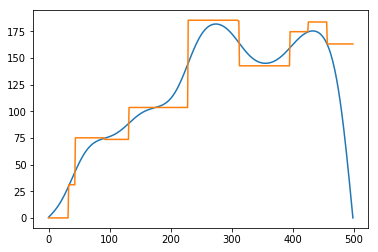

In [653]:
plt.plot(meas.numpy())
plt.plot(u.numpy())

In [334]:
Fw=torch.matrix_power(A, Ncount+0) + torch.eye(N)*1e-4
x1=np.linalg.solve(Fw,meas)

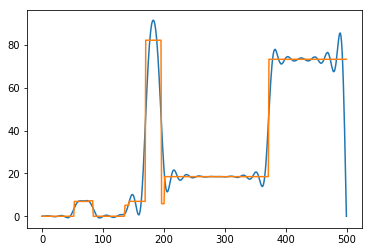

In [335]:
plt.plot(x1)
plt.plot(u.numpy())

C:\Users\wangr\AppData\Roaming\Python\Python36\site-packages\cvxpy\problems\problem.py:1268: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


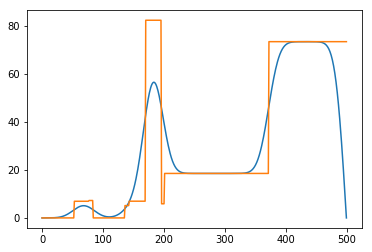

In [344]:
x_l1 = cp.Variable(shape=(N,1))
constraints = [x_l1>=0] #, cp.norm(Fw1.numpy()@x_l1-meas, 2)<=torch.norm(noise)]
# Form objective.
obj = cp.Minimize(cp.norm(D@x_l1, 1) + cp.norm(x_l1[:,0]-meas, 2)**2*1e3)
# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()
x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
plt.plot(x_l1.value)
plt.plot(u)

In [3]:
!pip install --upgrade --force-reinstall cvxpy --user

  Using cached https://files.pythonhosted.org/packages/1b/0c/3272e1f0acb8a6688d25b7682ab7a941d606534cd815c60ea71c50a55e70/cvxpy-1.1.12-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/09/3c/3a3165d7f1bd0b7a06ba4df4962ac3f1f88079252eb77b6da8ebd8de07b9/ecos-2.0.7.post1-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/ea/bc/da526221bc111857c7ef39c3af670bbcf5e69c247b0d22e51986f6d0c5c2/numpy-1.19.5-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/6d/76/251d71ce54eb1117218b7e232039da8aa56551d468789a7eb84d719725d2/osqp-0.6.2.post0-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/f3/9f/80522344838ae24cac9e945240436269cbb92349f7f1f4c9dfc10cb6bad5/scipy-1.5.4-cp36-cp36m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/d5/9e/f7b57ff533ee3a474c6afd6457b7154b514a9651c9ea4b804820dbeba1b8/qdldl-0.1.5.post0-cp36-cp36m-win_amd64.whl
  Found existing installatio

You are using pip version 9.0.1, however version 21.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [87]:
D = np.diag(np.ones((N,1))[:,0],0)-np.diag(np.ones((N-1,1))[:,0],-1)
print(D)

[[ 1.  0.  0. ...  0.  0.  0.]
 [-1.  1.  0. ...  0.  0.  0.]
 [ 0. -1.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  1.  0.  0.]
 [ 0.  0.  0. ... -1.  1.  0.]
 [ 0.  0.  0. ...  0. -1.  1.]]


In [613]:
def l1solv(Fw1,meas):
# Create variable.
   x_l1 = cp.Variable(shape=(N,1))
   constraints = [x_l1>=0] #, cp.norm(Fw1.numpy()@x_l1-meas, 2)<=torch.norm(noise)]
# Form objective.
   obj = cp.Minimize(cp.norm(D@x_l1, 1) + cp.norm((Fw1.numpy()@x_l1)[:,0]-meas, 2)**2*5e4)
# Form and solve problem.
   prob = cp.Problem(obj, constraints)
   prob.solve()
   x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
   plt.plot(x_l1.value)
   plt.plot(u)
 #  return torch.norm(x2,0.1)*1e-20#+torch.norm((Fw1@x2).reshape(500,1)-meas)*1e-2
   return net1(x2/np.linalg.norm(x2))#,torch.norm((Fw1@x2).reshape(500,1)-meas)*1e-10*2

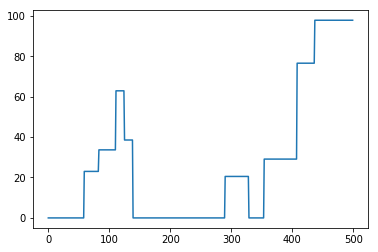

In [307]:
plt.plot(u)

tensor([0.0037], grad_fn=<SigmoidBackward>)

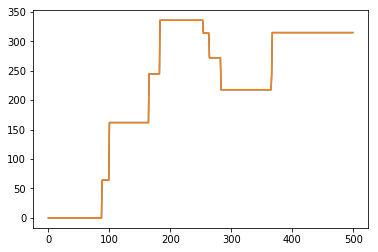

In [649]:
l1solv(torch.matrix_power(A, 500),meas)

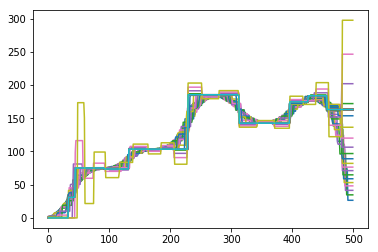

In [654]:
t = np.linspace(200,3000,20)
a =[]
for ti in range(20):
    a.append(l1solv(torch.matrix_power(A, int(t[ti])),meas))

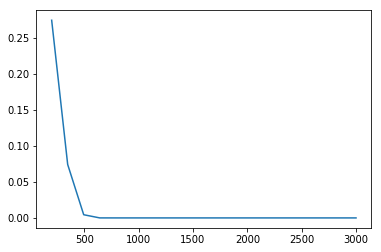

In [651]:
plt.plot(t,a)

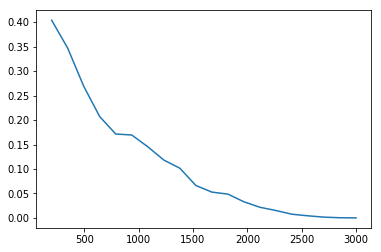

In [655]:
plt.plot(t,a)